In [106]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from collections import Counter

import pandas as pd
from metrics import metrics, metrics_balanced
import numpy as np

In [107]:
RS = 42

In [108]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("present", axis=1)  #.dropna()

eruptive_keywords = [
    "FU", "GCAS", "IN", "RCB", "SDOR", "UV", "WR", "RS", "TTAU", "FLARE"
]

pulsating_keywords = [
    "CEP", "CW", "DCEP", "DSCT", "M", "MIRA", "RR", "RV", "SR", 
    "SRA", "SRB", "SRC", "SRD", "BCEP", "ZZ", "ACYG", "SXPHE", "PVTEL", "BLBOO"
]

rotating_keywords = [
    "ROT", "BY", "ELL", "ACV", "FKCOM", "SXARI", "PSR"
]

eclipsing_keywords = [
    "E", "EA", "EB", "EW", "EC", "EL", "ALGOL", "BLYR", "WUMA"
]

def classify_type(vtype: str) -> str:
    """
    Возвращает укрупнённый класс переменной звезды
    в зависимости от содержимого строки vtype.
    """

    if pd.isna(vtype) or not isinstance(vtype, str) or vtype.strip() == "":
        return "UNKNOWN"  # Или "UNKNOWN", если хотите отдельно отметить NaN и пустые

    # Приведём к верхнему регистру для надёжного поиска подстрок
    t = vtype.upper()

    # --- 1) Затменные (Eclipsing Binaries) ---
    # Ищем любые подтипы: EA, EB, EW, EC, ELL, E/RS и т.д.
    # Включим также "E|" (встречается в комбинированных типах) и просто "E" (бывает)
    ecl_markers = ["EA", "EB", "EW", "EC", "ELL", "E/RS", "E|", "E "]
    if any(m in t for m in ecl_markers):
        return "ECLIPSING"

    # --- 2) Цефеиды и родственные (DCEP, CW, RV Tauri, ACEP) ---
    cep_markers = ["DCEP", "CW-FU", "CW", "CWA", "CWB", "RVA", "RV", "ACEP", "CEP"]
    # Примечание: "RV" может пересекаться с "RVC", "ROT" и пр.,
    # поэтому в реальном коде можно уточнять условия, но здесь — упрощённо.
    if any(m in t for m in cep_markers):
        return "CEPHEIDS"

    # --- 3) RR Лиры (RRAB, RRC, RRD, RR...) ---
    rr_markers = ["RRAB", "RRC", "RRD", "RR"]
    if any(m in t for m in rr_markers):
        return "RR_LYRAE"

    # --- 4) Короткопериодические пульсаторы: DSCT, SXPHE, GDOR, roAp ---
    short_puls = ["DSCT", "HADS", "SXPHE", "GDOR", "ROAP", "ROAM"]
    if any(m in t for m in short_puls):
        return "DELTA_SCUTI_ETC"

    # --- 5) Долгопериодические и полуправильные (M, SR, L) ---
    # Mira (M), SR, SRA, SRB, SRC, SRD, L, LB, LC, LPV
    lpv_markers = [" M ", "MIRA", "SR", "SRA", "SRB", "SRC", "SRD", "L ", "LB", "LC", "LPV"]
    # Для "M" можно проверять отдельно, чтобы не совпадало с "MISC", поэтому " M " с пробелами,
    # но тут для упрощения — любой "M". В реальном коде нужна аккуратность или RegEx.
    if any(m in t for m in lpv_markers):
        return "LONG_PERIOD"

    # --- 6) Ротационные переменные (BY, RS, ACV, SPB, ROT, GCAS) ---
    rot_markers = ["BY", "RS", "ACV", "SPB", "ROT", "GCAS"]
    if any(m in t for m in rot_markers):
        return "ROTATIONAL"

    # --- 7) Эруптивные/молодые звёзды (T Tauri, EXOR, UXOR, INS...) ---
    yso_markers = ["TTS", "EXOR", "UXOR", "INS", "IN", "INST", "CST"]  
    # "CST" иногда "constant?", но бывает и у молодых/неясных
    if any(m in t for m in yso_markers):
        return "YSO/ERUPTIVE"

    # --- Катаклизмические (UG, NL, AM, ZAND, IB, IS, ... ) ---
    cataclysmic_markers = ["UG", "NL", "AM", "ZAND", "IB", "ISB"]  # и др.
    if any(m in t for m in cataclysmic_markers):
        return "CATACLYSMIC"

    # --- 9) Горячие эмиссионные/WR/Be/симбиотические (WR, BE, FSCMa...) ---
    em_markers = ["WR", "BE", "FSCMA"]
    if any(m in t for m in em_markers):
        return "EMISSION_WR"

    # Если ничего не подошло, отправляем в "MISC" или "HYBRID"
    return "UNKNOWN"


# Теперь создаём новую колонку:
data["class"] = data["type"].apply(classify_type)
data.drop("type", axis=1, inplace=True)

# убрать "YSO/ERUPTIVE" и "EMISSION_WR"
data = data[(data['class'] != 'YSO/ERUPTIVE') & (data['class'] != 'EMISSION_WR')]

classes = data["class"].unique()
classes

array(['UNKNOWN', 'ROTATIONAL', 'ECLIPSING', 'DELTA_SCUTI_ETC',
       'CATACLYSMIC', 'RR_LYRAE', 'LONG_PERIOD', 'CEPHEIDS'], dtype=object)

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop("class", axis=1), data["class"], random_state=RS, train_size=0.8)

                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         8
       CEPHEIDS       1.00      1.00      1.00        11
DELTA_SCUTI_ETC       1.00      1.00      1.00      2045
      ECLIPSING       1.00      1.00      1.00       730
    LONG_PERIOD       1.00      1.00      1.00        31
     ROTATIONAL       1.00      1.00      1.00      1354
       RR_LYRAE       1.00      1.00      1.00       394

       accuracy                           1.00      4573
      macro avg       1.00      1.00      1.00      4573
   weighted avg       1.00      1.00      1.00      4573



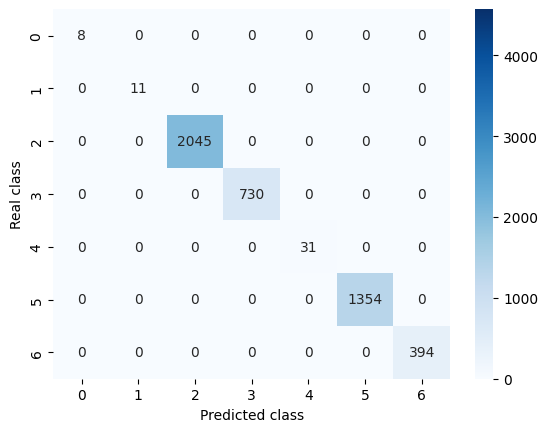

In [110]:
data_var = data[data['class'] != "UNKNOWN"]

X_train_var, X_test_var, Y_train_var, Y_test_var = train_test_split(
    data_var.drop("class", axis=1), data_var["class"], random_state=RS, train_size=0.8)

clf = HistGradientBoostingClassifier(max_iter=600, random_state=42, learning_rate=0.2, class_weight="balanced")
clf.fit(X_train_var, Y_train_var)

pred = clf.predict(X_train_var)
metrics(pred, Y_train_var, output=True, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.95      0.90      0.93       531
      ECLIPSING       0.71      0.77      0.74       163
    LONG_PERIOD       0.64      1.00      0.78         9
     ROTATIONAL       0.91      0.91      0.91       352
       RR_LYRAE       0.78      0.81      0.80        89

       accuracy                           0.88      1144
      macro avg       0.57      0.63      0.59      1144
   weighted avg       0.89      0.88      0.88      1144



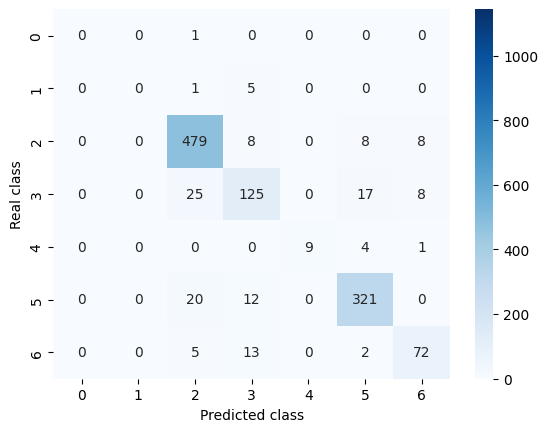

In [111]:
pred = clf.predict(X_test_var)
metrics(pred, Y_test_var, output=True, to_return=False)

#### Сначала определяем тип звезда, переменная или нет, потом уже классифицируем переменные.

In [112]:
data_single = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()
X_single, _, Y_single, _ = train_test_split(data_single.drop("present", axis=1), data_single["present"], random_state=RS, train_size=0.8)
N = Y_single[Y_single == 1].size
data_single = pd.concat([data_single[data_single.present == 0].sample(N * 3),
                         data_single[data_single.present == 1].sample(N)])
X, Y = data_single.drop("present", axis=1), data_single["present"]
# clf_single = HistGradientBoostingClassifier(max_iter=300, random_state=42, б learning_rate=0.2)
clf_single = RandomForestClassifier(max_depth=32, n_estimators=300, n_jobs=-1, random_state=42)
clf_single.fit(X, Y)

RandomForestClassifier(max_depth=32, n_estimators=300, n_jobs=-1,
                       random_state=42)

                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         4
       CEPHEIDS       0.50      0.40      0.44         5
DELTA_SCUTI_ETC       0.95      0.66      0.78       774
      ECLIPSING       0.89      0.71      0.79       209
    LONG_PERIOD       0.82      0.64      0.72        14
     ROTATIONAL       0.92      0.61      0.73       489
       RR_LYRAE       0.90      0.81      0.85       107
        UNKNOWN       0.96      1.00      0.98     11396

       accuracy                           0.95     12998
      macro avg       0.87      0.73      0.79     12998
   weighted avg       0.95      0.95      0.95     12998



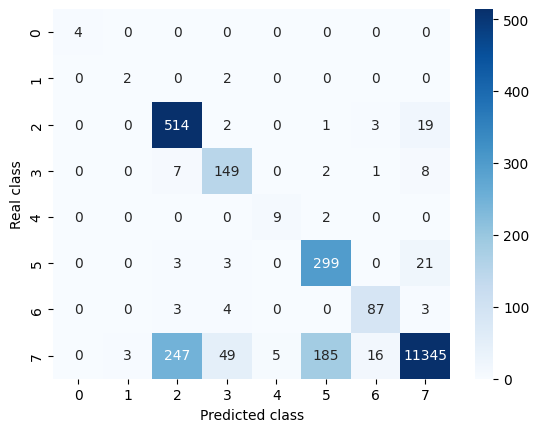

In [105]:
pred_all = clf_single.predict(X_test)

# отдельно предскажем переменные звезды
pred_var = clf.predict(X_test[pred_all == 1])

pred_res = []

j: int = 0
for i in pred_all:
  if i == 0:
    pred_res.append("UNKNOWN")
  else:
    pred_res.append(pred_var[j])
    j += 1

metrics_balanced(np.array(pred_res), Y_test, to_return=False)